In [1]:
import keras


Using TensorFlow backend.


# Dataset Preprocessing


### Einlesen der Daten aus dem JSON der BBL

In [2]:
import urllib.request, json 
with urllib.request.urlopen("http://statistik.easycredit-bbl.de/XML/exchange/540/Schedule.php?type=json&saison=2017&fixedGamesOnly=0") as url:
    games = json.loads(url.read().decode())
    print(json.dumps(games, indent=4, sort_keys=True))
    

{
    "competition": [
        {
            "@attributes": {
                "ID": "1",
                "title": "easyCredit BBL Hauptrunde"
            },
            "spiel": [
                {
                    "arenaLat": "49.77337",
                    "arenaLon": "9.93923",
                    "arenaName": "S.Oliver-Arena",
                    "bbl_spielID": "20826",
                    "datum": "2017-09-29",
                    "gast": "Brose Bamberg",
                    "gastCity": "Brose Bamberg",
                    "gast_id": "420",
                    "gast_result": "73",
                    "home": "s.Oliver W\u00fcrzburg",
                    "homeCity": "W\u00fcrzburg",
                    "home_id": "540",
                    "home_result": "76",
                    "init_url": "http://live.beko-bbl.de/data/bbl/540/20826.JSN",
                    "live_url": "http://live.beko-bbl.de/data/bbl/540/20826.JSN",
                    "spiel_nummer": "0",
                 

### Daten aufbereiten

#### Erstellen einer Liste für die Arenen & Teams

In [3]:
arena=[]
home_ids=[]
for i in range(0,len(games['competition'][0]['spiel'])):
               
    if games['competition'][0]['spiel'][i]['home_id'] not in home_ids:
        arena.append(games['competition'][0]['spiel'][i]['arenaName'])
        home_ids.append(games['competition'][0]['spiel'][i]['home_id'])    
print(len(arena)) #Um sicher zu gehen, dass alle Arenen vorhanden sind
print(len(home_ids)) #Um sicher zu gehen, dass alle Teams vorhanden sind

18
18


#### Datum + Uhrzeit auslesen

In [4]:
from datetime import datetime

datetime_object = datetime.strptime(games['competition'][0]['spiel'][0]['datum']+" "+games['competition'][0]['spiel'][0]['uhrzeit']  , '%Y-%m-%d %H:%M:%S')

print(datetime_object)
print(datetime_object.strftime('%U'))
print(datetime_object.strftime('%w'))


2017-09-29 20:30:00
39
5


#### Erstellen eines dictionary für die Hallenkapazitäten

In [5]:
arenakap = {486:6594,413:14500,433:4200,420:6150,415:6000,425:3300,430:6000,426:5002,540:3140,418:6200,421:4003,422:3603,483:3076,477:3447,428:3000,439:4200,517:3533,432:3132}
print(arenakap)
print(len(arenakap))


{486: 6594, 413: 14500, 433: 4200, 420: 6150, 415: 6000, 425: 3300, 430: 6000, 426: 5002, 540: 3140, 418: 6200, 421: 4003, 422: 3603, 483: 3076, 477: 3447, 428: 3000, 439: 4200, 517: 3533, 432: 3132}
18


### Dataset zusammenstellen 

In [6]:
dataset=[]
calendarWeeks=[]
weekDays=[]

for i in range(0,len(games['competition'][0]['spiel'])):
    datasetrow=[]     
    datasetrow.append(games['competition'][0]['spiel'][i]['home_id'])
    datasetrow.append(games['competition'][0]['spiel'][i]['gast_id'])
    datasetrow.append(int(games['competition'][0]['spiel'][i]['home_result']>games['competition'][0]['spiel'][i]['gast_result']))
    datasetrow.append(int(games['competition'][0]['spiel'][i]['zuschauer']))
    datasetrow.append(arenakap[int(games['competition'][0]['spiel'][i]['home_id'])])
    datetime_object = datetime.strptime(games['competition'][0]['spiel'][i]['datum']+" "+games['competition'][0]['spiel'][i]['uhrzeit']  , '%Y-%m-%d %H:%M:%S')
    kw = datetime_object.strftime('%U')
    datasetrow.append(datetime_object.strftime('%U'))
    if kw not in calendarWeeks:
        calendarWeeks.append(kw)
    days = datetime_object.strftime('%w')
    datasetrow.append(datetime_object.strftime('%w'))
    if days not in weekDays:
        weekDays.append(days)
    
    dataset.append(datasetrow)

print(dataset)
#print(calendarWeeks)
#print(weekDays)
# Eingangsneuronen - abhängig vom Dataset --> KW (32) Days (7)

[['540', '420', 1, 3140, 3140, '39', '5'], ['422', '439', 1, 2316, 3603, '39', '5'], ['483', '426', 0, 2071, 3076, '39', '5'], ['418', '413', 0, 6200, 6200, '39', '6'], ['477', '430', 0, 2703, 3447, '39', '6'], ['421', '486', 0, 3618, 4003, '39', '6'], ['432', '425', 0, 2850, 3132, '39', '6'], ['428', '517', 1, 2500, 3000, '39', '6'], ['413', '439', 0, 8877, 14500, '40', '1'], ['420', '421', 1, 6150, 6150, '40', '2'], ['426', '477', 1, 4640, 5002, '40', '2'], ['483', '540', 0, 2292, 3076, '40', '2'], ['425', '428', 1, 3211, 3300, '40', '2'], ['486', '422', 0, 6123, 6594, '40', '2'], ['517', '430', 0, 2465, 3533, '40', '2'], ['415', '418', 1, 4670, 6000, '40', '3'], ['439', '433', 0, 2480, 4200, '40', '4'], ['413', '432', 1, 7543, 14500, '40', '5'], ['517', '420', 0, 2391, 3533, '40', '5'], ['477', '486', 0, 3125, 3447, '40', '6'], ['418', '425', 0, 6200, 6200, '40', '6'], ['428', '413', 0, 2650, 3000, '41', '0'], ['430', '483', 1, 5018, 6000, '41', '0'], ['540', '439', 1, 3021, 3140, '

#### Umwandlung des Datasets in ein Numpy Array 

In [7]:
import numpy as np
# : -> auslesen aller zeilen
dataset=np.asarray(dataset)
#print(dataset[:,0])
#print(len(dataset))

#### One hot encoding der Teams, Wochentage, Kalendarwochen




In [8]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
transformed_home_ids = encoder.fit_transform(dataset[:,0])

print(transformed_home_ids)

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


In [9]:
transformed_gast_ids = encoder.transform(dataset[:,1]) #ohne fit, damit die Teams eindeutig bleiben, nur transformation notwendig
print(transformed_gast_ids)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [11]:
transformed_calendarWeek = encoder.fit_transform(dataset[:,5])
print(len(transformed_calendarWeek[0])) #reguläre Saison geht über 32 KW
transformed_weekDay = encoder.fit_transform(dataset[:,6])
print(len(transformed_weekDay[0])) #Spiele an alle Wochentage

32
7


In [12]:
# Umformung der Zuschauer in eine Spalte (vorher war es nur eine Zeile)
#print(np.reshape(dataset[:,3],(306,1)))
# -> siehe Featurescaling

#### Featurescaling der Zuschaueranzahl & Hallenkapazitäten


In [15]:
from sklearn.preprocessing import MinMaxScaler

arenaKap_scaler=MinMaxScaler()
arenaKap_scaler.fit([[0],[14500]]) #Maximum Berlin und 0 Minimum
#reshaping
transformed_zuschauer=arenaKap_scaler.transform(np.reshape(dataset[:,3],(306,1)))
transformed_kap=arenaKap_scaler.transform(np.reshape(dataset[:,4],(306,1)))
print(transformed_kap)
#print(transformed_zuschauer)

[[0.21655172]
 [0.24848276]
 [0.21213793]
 [0.42758621]
 [0.23772414]
 [0.27606897]
 [0.216     ]
 [0.20689655]
 [1.        ]
 [0.42413793]
 [0.34496552]
 [0.21213793]
 [0.22758621]
 [0.45475862]
 [0.24365517]
 [0.4137931 ]
 [0.28965517]
 [1.        ]
 [0.24365517]
 [0.23772414]
 [0.42758621]
 [0.20689655]
 [0.4137931 ]
 [0.21655172]
 [0.216     ]
 [0.24848276]
 [0.27606897]
 [0.28965517]
 [0.34496552]
 [0.4137931 ]
 [0.23772414]
 [0.45475862]
 [0.21213793]
 [0.28965517]
 [0.216     ]
 [0.4137931 ]
 [0.22758621]
 [0.42758621]
 [1.        ]
 [0.24848276]
 [0.20689655]
 [0.45475862]
 [0.27606897]
 [0.21655172]
 [0.27606897]
 [1.        ]
 [0.24848276]
 [0.23772414]
 [0.4137931 ]
 [0.28965517]
 [0.4137931 ]
 [0.28965517]
 [0.34496552]
 [0.42758621]
 [0.21655172]
 [0.45475862]
 [0.20689655]
 [0.21213793]
 [0.42413793]
 [0.22758621]
 [0.216     ]
 [0.24365517]
 [0.23772414]
 [0.24848276]
 [0.27606897]
 [0.216     ]
 [0.21213793]
 [0.28965517]
 [1.        ]
 [0.34496552]
 [0.28965517]
 [0.42

### Zusammenfügen der Spalten home_ids, gast_ids,  zuschauer, Hallenkapazität, home_win, calendarWeek, weekDay

In [22]:
data=np.c_[transformed_home_ids,transformed_gast_ids,transformed_zuschauer,transformed_kap,transformed_calendarWeek,transformed_weekDay,dataset[:,2]]
np.random.shuffle(data)
print(data)

[['0' '1' '0' ... '0' '1' '0']
 ['0' '0' '0' ... '1' '0' '0']
 ['0' '0' '0' ... '0' '1' '1']
 ...
 ['0' '0' '0' ... '0' '1' '0']
 ['1' '0' '0' ... '0' '1' '1']
 ['1' '0' '0' ... '0' '1' '0']]


In [23]:
print(len(data[0])) #Anzahl der Neuronen
neuronen = len(data[0])-1

78


# Netz Modellierung

In [24]:
# Importing the Keras libraries and packages 
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

adam = optimizers.Adam(lr=0.001) # lernrate

# Initialising the ANN
regressor = Sequential()

# Adding the input layer and the first hidden layer
regressor.add(Dense(units = neuronen, kernel_initializer = 'uniform', activation = 'relu', input_shape = (neuronen,)))

# Adding the second hidden layer
#regressor.add(Dense(units = 18, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
regressor.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

#Summary anzeigen
regressor.summary()

# Compiling the ANN - wie soll es lernen
regressor.compile(optimizer = adam, loss = 'mean_squared_error', metrics = ['accuracy'])#binary_crossentropy

# Fitting the ANN to the Training set 
#input = data[:,0:4] output= (data[:,4]
history = regressor.fit(data[:,0:neuronen], data[:,neuronen], batch_size = 10, epochs = 100, validation_split = 0.3)





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 77)                6006      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 78        
Total params: 6,084
Trainable params: 6,084
Non-trainable params: 0
_________________________________________________________________
Train on 214 samples, validate on 92 samples
Epoch 1/100
214/214 [==============================] - 0s 928us/step - loss: 0.2491 - acc: 0.5794 - val_loss: 0.2484 - val_acc: 0.5326
Epoch 2/100
214/214 [==============================] - 0s 191us/step - loss: 0.2452 - acc: 0.5935 - val_loss: 0.2464 - val_acc: 0.5435
Epoch 3/100
214/214 [==============================] - 0s 194us/step - loss: 0.2393 - acc: 0.6121 - val_loss: 0.2430 - val_acc: 0.5870
Epoch 4/100
214/214 [==============================] - 0s 199us/step - loss: 0.2295 - 

214/214 [==============================] - 0s 219us/step - loss: 0.0207 - acc: 0.9907 - val_loss: 0.3006 - val_acc: 0.5652
Epoch 57/100
214/214 [==============================] - 0s 218us/step - loss: 0.0199 - acc: 0.9907 - val_loss: 0.3010 - val_acc: 0.5652
Epoch 58/100
214/214 [==============================] - 0s 204us/step - loss: 0.0191 - acc: 0.9953 - val_loss: 0.3015 - val_acc: 0.5652
Epoch 59/100
214/214 [==============================] - 0s 193us/step - loss: 0.0182 - acc: 0.9953 - val_loss: 0.3017 - val_acc: 0.5652
Epoch 60/100
214/214 [==============================] - 0s 184us/step - loss: 0.0173 - acc: 0.9953 - val_loss: 0.3022 - val_acc: 0.5652
Epoch 61/100
214/214 [==============================] - 0s 187us/step - loss: 0.0167 - acc: 0.9953 - val_loss: 0.3036 - val_acc: 0.5652
Epoch 62/100
214/214 [==============================] - 0s 187us/step - loss: 0.0161 - acc: 0.9953 - val_loss: 0.3030 - val_acc: 0.5652
Epoch 63/100
214/214 [==============================] - 0s 20

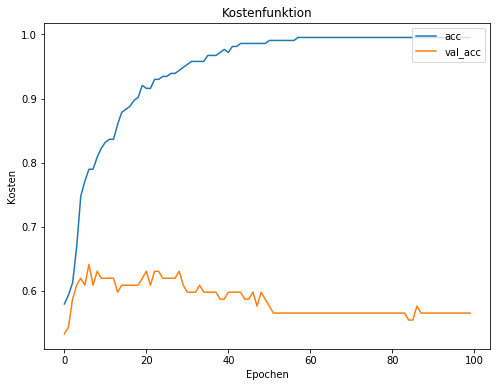

In [25]:
#
import matplotlib.pyplot as plt

handles = []

label, = plt.plot(history.history['acc'], label="acc")
handles.append(label)
label, = plt.plot(history.history['val_acc'], label="val_acc")
handles.append(label)
plt.title('Kostenfunktion')
plt.ylabel('Kosten')
plt.xlabel('Epochen')
plt.legend(handles=handles, loc='upper right')
figure = plt.gcf() # get current figure
figure.set_size_inches(8, 6) # um die größe des Plots anzupassen
#plt.savefig(pathpathpaht) # hiermit kannst das ding als auch als bild an dem angegebenen ort plus name ablegen
plt.show()



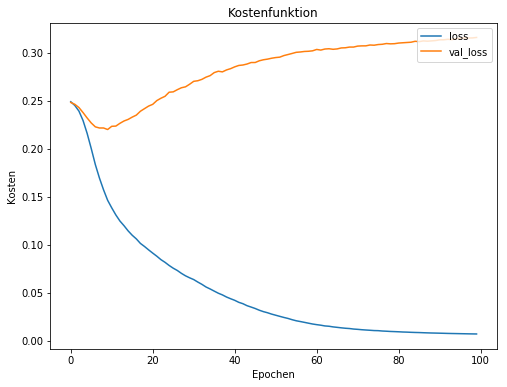

In [26]:
handles = []

label, = plt.plot(history.history['loss'], label="loss")
handles.append(label)
label, = plt.plot(history.history['val_loss'], label="val_loss")
handles.append(label)
plt.title('Kostenfunktion')
plt.ylabel('Kosten')
plt.xlabel('Epochen')
plt.legend(handles=handles, loc='upper right')
figure = plt.gcf() # get current figure
figure.set_size_inches(8, 6) # um die größe des Plots anzupassen
#plt.savefig(pathpathpaht) # hiermit kannst das ding als auch als bild an dem angegebenen ort plus name ablegen
plt.show()

### Netz als Pickle Datei speichern

In [ ]:
import time as tm
import datetime
import pickle
      
        
def create_file_name():
    ts = tm.time()
    name = datetime.datetime.fromtimestamp(ts).strftime('%Y%m%d%H%M%S') + '_ann'
    return name

path='./Netze/' #Pfad muss angepasst werden
name_file= create_file_name()



In [ ]:
with open(path + name_file + '.pkl', 'wb') as output:
    ann_net = {'history_val_loss':history.history['val_loss'],'history_loss':history.history['loss']}
    pickle.dump(ann_net, output)